# Section 2.2.2: Exponential Time-to-Event Prediction Model Demo (Rotterdam/GBSG datasets)

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo is nearly identical to the exponential time-to-event prediction model demo for the SUPPORT dataset (`S2.2.2_Exponential.ipynb`). The only difference is that this notebook instead applies the model to the Rotterdam tumor bank (Foekens et al., 2000) and GBSG datasets (Schumacher et al., 1994). These datasets are of breast cancer patients who are node-positive. The outcome of interest is recurrence-free survival time (namely, the number of months starting from primary surgery until death or disease recurrence--whichever happened sooner). Specifically, we train on the Rotterdam dataset and test on the GBSG dataset, as is done in the DeepSurv paper (Katzman et al., 2018).

Importantly, the only change to the code is in loading in the data. The rest of the code in the notebook is actually the same as for the SUPPORT dataset!

### Loading in the Rotterdam/GBSG datasets

We have written code already that loads in the Rotterdam/GBSG datasets. Note that unlike in the SUPPORT dataset, where the full training set and the test set are obtained via a random split, here we treat the Rotterdam dataset as the full training set and the GBSG dataset as the test set. In more detail, our data loading code does the following:

- Randomly split the Rotterdam tumor bank dataset into 80%/20% train/validation sets.
- Treat the GBSG data as the test set.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('rotterdam-gbsg')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 1236
Validation set size 310
Test set size 686

Features before preprocessing (7 total):
['horTh', 'tsize', 'menostat', 'age', 'pnodes', 'progrec', 'estrec']

Features after preprocessing (7 total):
['horTh', 'tsize_norm', 'menostat', 'age_std', 'pnodes_std', 'progrec_std', 'estrec_std']

Events: ['death']



We fit and apply a preprocessor that we have written (see `datasets.py` for details on preprocessing) to get a "standardized" or "normalized" version of the training set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
print('Number of features before preprocessing:', X_train_raw_np.shape[1])
print('Number of features after preprocessing:', X_train_np.shape[1])

Number of features before preprocessing: 7
Number of features after preprocessing: 7


Much like how we wouldn't learn the preprocessor function so that it peeks at the true test set, we don't learn the preprocessor function so that it peeks at the validation set either. For this reason, notice that earlier we constructed the `preprocessor` object only using the training set and *not* also the validation set. We can apply the already learned `preprocessor` object (fitted to the training set) now to the validation set.

In [3]:
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Quick display of what the tabular data look like before and after preprocessing

Here's what the raw features look like:

In [4]:
import pandas as pd
X_train_raw_df = pd.DataFrame(X_train_raw_np, columns=features_before_preprocessing)
X_train_raw_df.head()

,horTh,tsize,menostat,age,pnodes,progrec,estrec
0,0.0,0.0,0.0,48.0,1.0,805.0,198.0
1,0.0,1.0,1.0,74.0,1.0,166.0,382.0
2,1.0,0.0,1.0,67.0,6.0,92.0,339.0
3,0.0,1.0,0.0,48.0,1.0,635.0,411.0
4,0.0,1.0,0.0,57.0,2.0,23.0,0.0


Here's what the features look like after preprocessing:

In [5]:
X_train_df = pd.DataFrame(X_train_np, columns=features_after_preprocessing)
X_train_df.head()

,horTh,tsize_norm,menostat,age_std,pnodes_std,progrec_std,estrec_std
0,0.0,0.0,0.0,-0.631631,-0.855306,2.190318,0.152950
1,0.0,0.5,1.0,1.379873,-0.855306,0.046580,0.898470
2,1.0,0.0,1.0,0.838314,0.173659,-0.201678,0.724245
3,0.0,0.5,0.0,-0.631631,-0.855306,1.619996,1.015970
4,0.0,0.5,0.0,0.064659,-0.649513,-0.433162,-0.649294


### Preparing training and validation sets for use with PyTorch

Note that we use a CUDA GPU if it is available.

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up an exponential time-to-event prediction model

In the monograph, specifically for equation (2.6), we set

$$\mathbf{h}(t|x;\theta) := e^{\beta^\top x + \psi}.$$

How we implement this in code is that we actually model the *log* of $\mathbf{h}(t|x;\theta)$:

$$\log \mathbf{h}(t|x;\theta) = \beta^\top x + \psi.$$

As this just corresponds to a linear model, we can use PyTorch's `nn.Linear`, where the number of input features corresponds to the number of dimensions in $x$, the number of output features is 1, and--by default--`nn.Linear` includes a bias term (which will correspond to the $\psi$ variable above). Note that the linear model's weights correspond to what we called $\beta$.

In [7]:
import torch.nn as nn

torch.manual_seed(0)

num_input_features = X_train.size(1)

# simple neural net model that just does an inner product + a bias
# (note that constructing an nn.Linear object also does random
# parameter initialization)
log_hazards_model = nn.Linear(num_input_features, 1).to(device)

Right now the parameters have been randomly initialized as follows:

In [8]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[-0.0028,  0.2028, -0.3111, -0.2782, -0.1456,  0.1014, -0.0075]],
       device='cuda:0', requires_grad=True)

In [9]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([0.2997], device='cuda:0', requires_grad=True)

### Specifying the training loss function

In [10]:
def exp_nll_loss(predicted_log_hazards, Y_true, D_true):
    # the three inputs should all be 1D PyTorch tensors with the same number of entries

    # the loss is precisely L_{Hazard-NLL} given in Example 2.2.2 of the monograph
    return -(D_true * predicted_log_hazards - Y_true * (predicted_log_hazards.exp())).mean()

### Training the model using minibatch gradient descent

As an illustrative example, in this code, we use the validation set to decide on whether to use a previous epoch's learned model parameters. This could be viewed as a form of hyperparameter tuning where we are effectively selecting how many epochs to train the model for based on whichever achieves the best validation set loss.

In [11]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(log_hazards_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    log_hazards_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        log_hazards_batch = log_hazards_model(X_batch).view(-1)
        loss_batch = exp_nll_loss(log_hazards_batch, Y_batch, D_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    log_hazards_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            train_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            val_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(log_hazards_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
log_hazards_model.load_state_dict(best_params)

Epoch 1 - train loss 11.039381980895996 - val loss 10.920942306518555
Epoch 2 - train loss 5.348545074462891 - val loss 5.13672399520874
Epoch 3 - train loss 4.35257625579834 - val loss 4.1131510734558105
Epoch 4 - train loss 4.071681976318359 - val loss 3.814147472381592
Epoch 5 - train loss 3.9604241847991943 - val loss 3.6909306049346924
Epoch 6 - train loss 3.9057838916778564 - val loss 3.630040168762207
Epoch 7 - train loss 3.871673345565796 - val loss 3.5917775630950928
Epoch 8 - train loss 3.8466556072235107 - val loss 3.564443588256836
Epoch 9 - train loss 3.8259243965148926 - val loss 3.5412628650665283
Epoch 10 - train loss 3.808465003967285 - val loss 3.5221967697143555
Epoch 11 - train loss 3.7929275035858154 - val loss 3.504974126815796
Epoch 12 - train loss 3.7787766456604004 - val loss 3.4900894165039062
Epoch 13 - train loss 3.7653963565826416 - val loss 3.4756863117218018
Epoch 14 - train loss 3.7532386779785156 - val loss 3.461940288543701
Epoch 15 - train loss 3.7422

<All keys matched successfully>

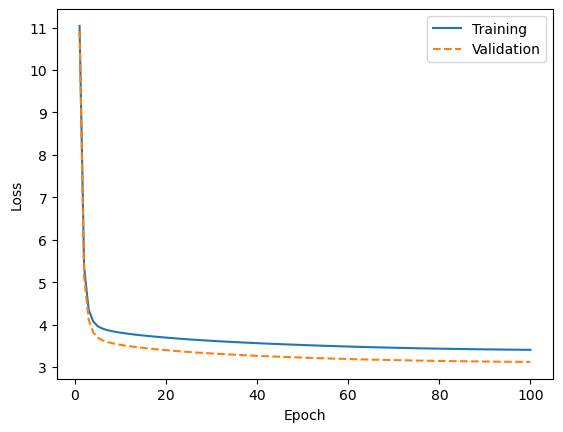

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the model, the model parameters are as follows:

In [13]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[-0.0490, -0.1835, -0.6231,  0.3290,  0.1977, -0.0458, -0.0363]],
       device='cuda:0', requires_grad=True)

In [14]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([-3.8052], device='cuda:0', requires_grad=True)

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [15]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor)

Next, we apply the neural net model to the test data. We convert the resulting log hazard values to NumPy arrays since the plotting and evaluation code later on does not need nor use PyTorch.

In [16]:
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
with torch.no_grad():
    log_hazards_test = log_hazards_model(X_test)
    log_hazards_test_np = log_hazards_test.cpu().numpy()
print(log_hazards_test_np.shape)

(686, 1)


To back out a survival curve, for simplicity we just use a time grid specified by the unique times in the test data (this is not the only way to specify a time grid; for examples of other ways, see Section 2.3.2 of the monograph).

In [17]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)
surv_test_np = np.exp(-time_grid_test_np*np.exp(log_hazards_test_np))  # equation (2.8) of the monograph applied to every test point
print(surv_test_np.shape)

(686, 574)


Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

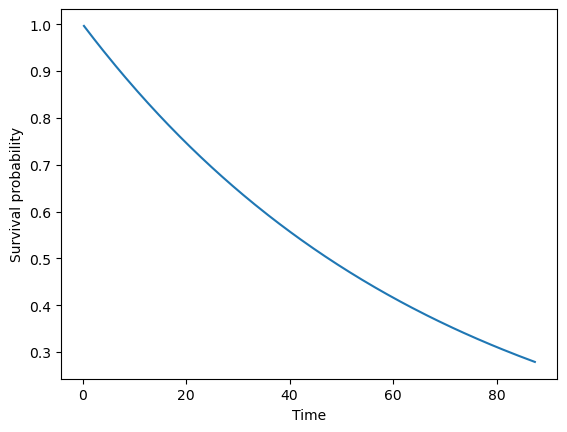

In [18]:
plt.plot(time_grid_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Concordance index (Harrell et al., 1982) using the scikit-survival implementation (Pölsterl, 2020)

In [19]:
from sksurv.metrics import concordance_index_censored

C_index = concordance_index_censored(D_test_np.astype(bool), Y_test_np, log_hazards_test_np.flatten())[0]
print(f"Harrell's concordance index: {C_index}")

Harrell's concordance index: 0.5766201755440664


#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

We had mentioned in the monograph that time-dependent concordance index (Antolini et al., 2005) becomes the same as Harrell's concordance index when the proportional hazards assumption holds, but we had mentioned this in the context where we do not treat ties (in predicted log hazards) in a special manner (i.e., we just apply Definitions 2.4.1 and 2.4.2 of the monograph). When there are ties, the code here handles ties a bit differently which is why it is possible for Harrell's concordance index to be close to but not identical to Antolini et al.'s time-dependent concordance index.

In [20]:
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.5766126608151978


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

The training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [21]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 18.365503311157227 - truncated time-dependent concordance: 0.5907428144924503
Eval time 34.891170501708984 - truncated time-dependent concordance: 0.5913295927370565
Eval time 55.195072174072266 - truncated time-dependent concordance: 0.5703883230825377


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [22]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 18.365503311157227 - time-dependent AUC: 0.5940699751073386
Eval time 34.891170501708984 - time-dependent AUC: 0.6100096678341871
Eval time 55.195072174072266 - time-dependent AUC: 0.5520558565050695


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [23]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 18.365503311157227 - Brier score: 0.15754649136867882
Eval time 34.891170501708984 - Brier score: 0.21402761630320982
Eval time 55.195072174072266 - Brier score: 0.19387449415779673
Integrated Brier score: 0.1391653176492881


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

We reuse the `eval` object defined in the previous code cell. However, we point out that we actually do *not* need to provide training labels. In other words, the code cell below would still run if we started it by re-defining the `eval` object as follows:

```
eval = SurvivalEvaluator(surv_test_np, time_grid_test_np, Y_test_np, D_test_np)
```

In [24]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

The training data are used to fit a Kaplan-Meier estimator (which is used in both the margin and PO approaches for getting a pseudo ground truth survival time for censored data; also, this Kaplan-Meier estimator is also used to compute weights for different censored evaluation data points).

In [25]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 27.93611640257301


In [26]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 31.52283437264418
